In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- If youve already done this for Ne, you dont need to do here too

In [2]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.11.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [3]:
import DiadFit as pf
pf.__version__

'0.0.18'

In [4]:
# Add the path with your spectra in
mypath=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Weak_Diad_BenBlack'

In [5]:
# This specifies what file type your Raman exported in. 
filetype='head_csv'
# Specifying the extension here helps to filter out other file types,
# e.g. png files that may be in the folder
file_ext='.csv'
# If your instrument appends a nubmer like 01, 02 to each file, prefix=True removes it
prefix=False

## This function finds all files in your path with the specified file format
- As you will fit your Ne lines in a different workbook, you can use 'exclude_str' to put any text that appears in all your Ne files, and it won't look here

In [6]:
Diad_files=pf.get_diad_files(path=mypath, file_ext=file_ext, exclude_str='Ne')
Diad_files

exclude type
.png


['002_K9_1.csv',
 '004_K9_2.csv',
 '006_K13_1.csv',
 '007_k9.csv',
 '008_K13_2.csv']

## Select the first file you want to fit
- This allows you to tweak parameters for your spectra and your instrument

In [7]:
filename=Diad_files[4] # This finds the first file

# Alternatively, you can specify the actual file name if you want to fit a specific one
#filename='007_k9.csv'
print(filename)

008_K13_2.csv


## First we plot the spectra
- This lets you look at the spectra, decide how strong your hotbands are, and see how elevated the diads are (if they are very elevated, you may need to fit a gaussian background too)

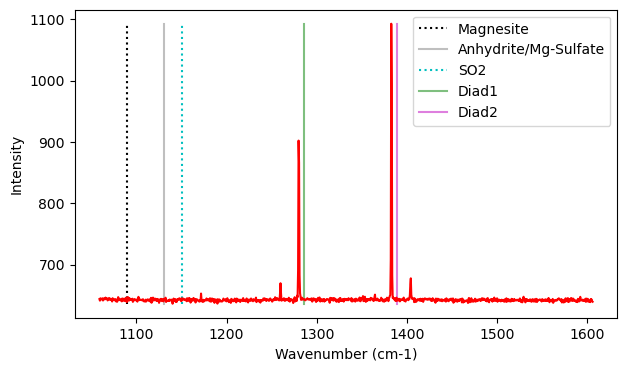

In [8]:
pf.plot_diad(path=mypath, filename=filename, filetype=filetype)

## After inspecting the spectra, decide if you want to fit the carbonate peak
- First, look at the presets, you can edit them in carb_peak_config by typing the variable name, and a new value

In [9]:
# Decide if you want to fit a carbonate peak or not here. 
fit_carbonate=False

# Tweak options here, can exclude a range for example using exclude_range=Tuple[float, float]
Carb_Config=pf.carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330))
Carb_Config   

carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330), N_poly_carb_bck=1, amplitude=1000, cent_carbonate=1090, outlier_sigma=12, N_peaks=3, distance=10, prominence=5, width=6, threshold=0.1, exclude_range=None, dpi=100, plot_figure=True)

## This actually does the work fitting the carbonate peak

In [10]:
Carb_fit=pf.fit_carbonate_peak(config=Carb_Config, path=mypath, 
filename=filename, filetype=filetype,
fit_carbonate=fit_carbonate)
Carb_fit

## Now lets plot the diads
- As with carbonate, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

In [11]:
diad_id_config=pf.diad_id_config()
diad_id_config

diad_id_config(exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1385), approx_diad1_pos=(1275, 1280), height=400, distance=5, threshold=0.5, width=0.5, prominence=10, plot_figure=True)

Initial estimates: Diad1+HB=[1279.9 1259.8], Diad2+HB=[1382.7 1404.4]


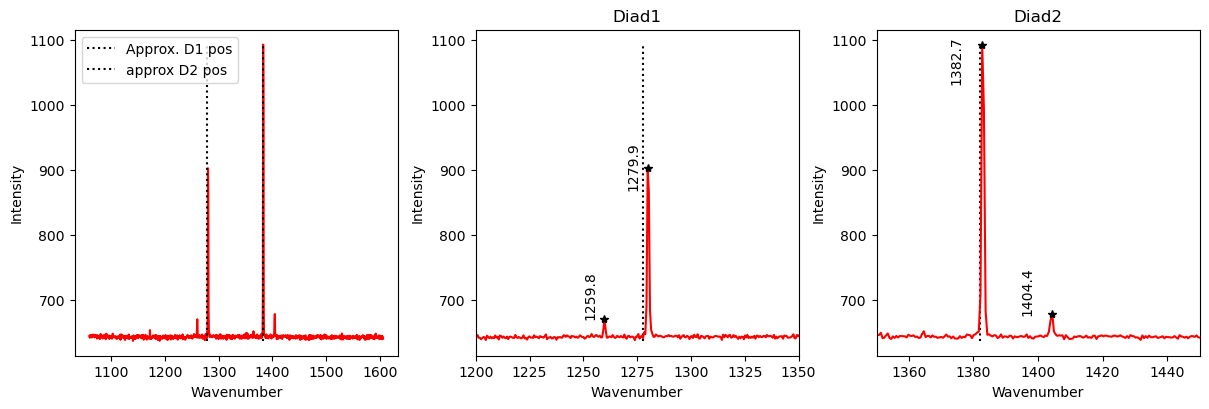

In [12]:
# Specify the number of peaks, 1 = just peak, 2 = Peak+hot bands
n_peaks_diad1=2
n_peaks_diad2=2 

    
diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config, path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, n_peaks_diad2=n_peaks_diad2)

In [13]:
type(diad1_peaks)

tuple

## If you have no diads visible...
- change True to False, and it will just save the carbonate peak parameters

In [12]:
diads_present=True
pf.proceed_to_fit_diads(filename, Carb_fit, diads_present=diads_present)

Move on to fit diads


## Fit Diad 1
- This function uses the guess of the peak parameters above. 
- For very dense diads, you may need to fit a gaussian background, defined by peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000
- Otherwise, the background is fitted with a polynomial you can set the degree for (Default =1) based on background positoins defined by lower_bck, upper_bck...
- If plot_figure=True, it saves the figure in its own folder in the path, so you can inspect all the fits at a later date. 

In [13]:
diad1_fit_config=pf.diad1_fit_config(x_range_residual=10, x_range_baseline=10,
                                    HB_amplitude=5, diad_amplitude=100)
diad1_fit_config

diad1_fit_config(peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000, N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1300, 1350), diad_amplitude=100, HB_amplitude=5, x_range_baseline=10, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

Making summary figure of different fits for saving


,Diad1_Cent,Diad1_Area,HB1_Cent,HB1_Area,Residual_Diad1
0,1280.117202,354.027089,1259.827333,32.018928,1.397676


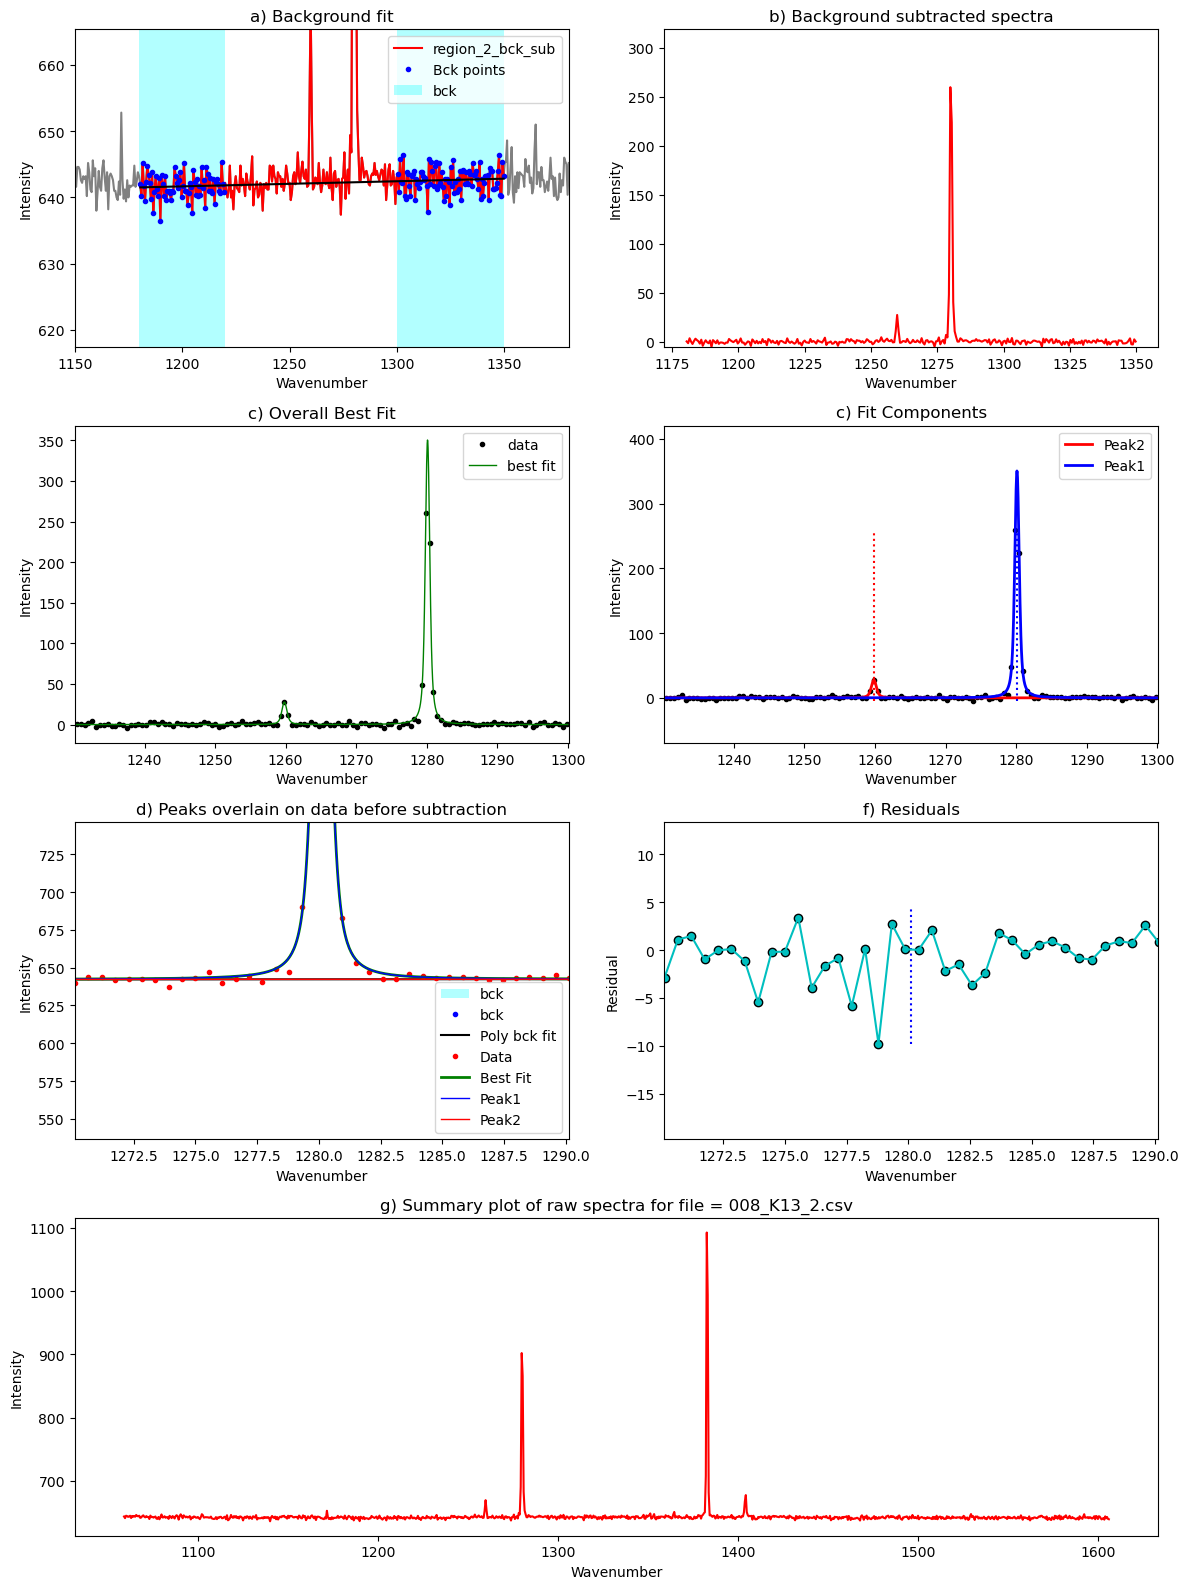

In [14]:
# For very dense spectra, with a very elevated background, you'll need to add a gaussian fit
# If you put a number in brackets, it'll center a gaussian extra background near there. 

# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad1_fit

## Fit diad 2

In [15]:
diad2_fit_config=pf.diad2_fit_config(x_range_residual=10, x_range_baseline=10)
diad2_fit_config

diad2_fit_config(peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000, N_poly_bck_diad2=1, lower_bck_diad2=(1300, 1360), upper_bck_diad2=(1440, 1470), diad_amplitude=100, HB_amplitude=20, x_range_baseline=10, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

1382.9279739321796
<Parameter 'sigma', value=0.16341239834033727 +/- 0.00611, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')


,Diad2_Cent,Diad2_Area,HB2_Cent,HB2_Area,Residual_Diad2
0,1382.928021,555.369636,1404.203157,48.592651,1.710057


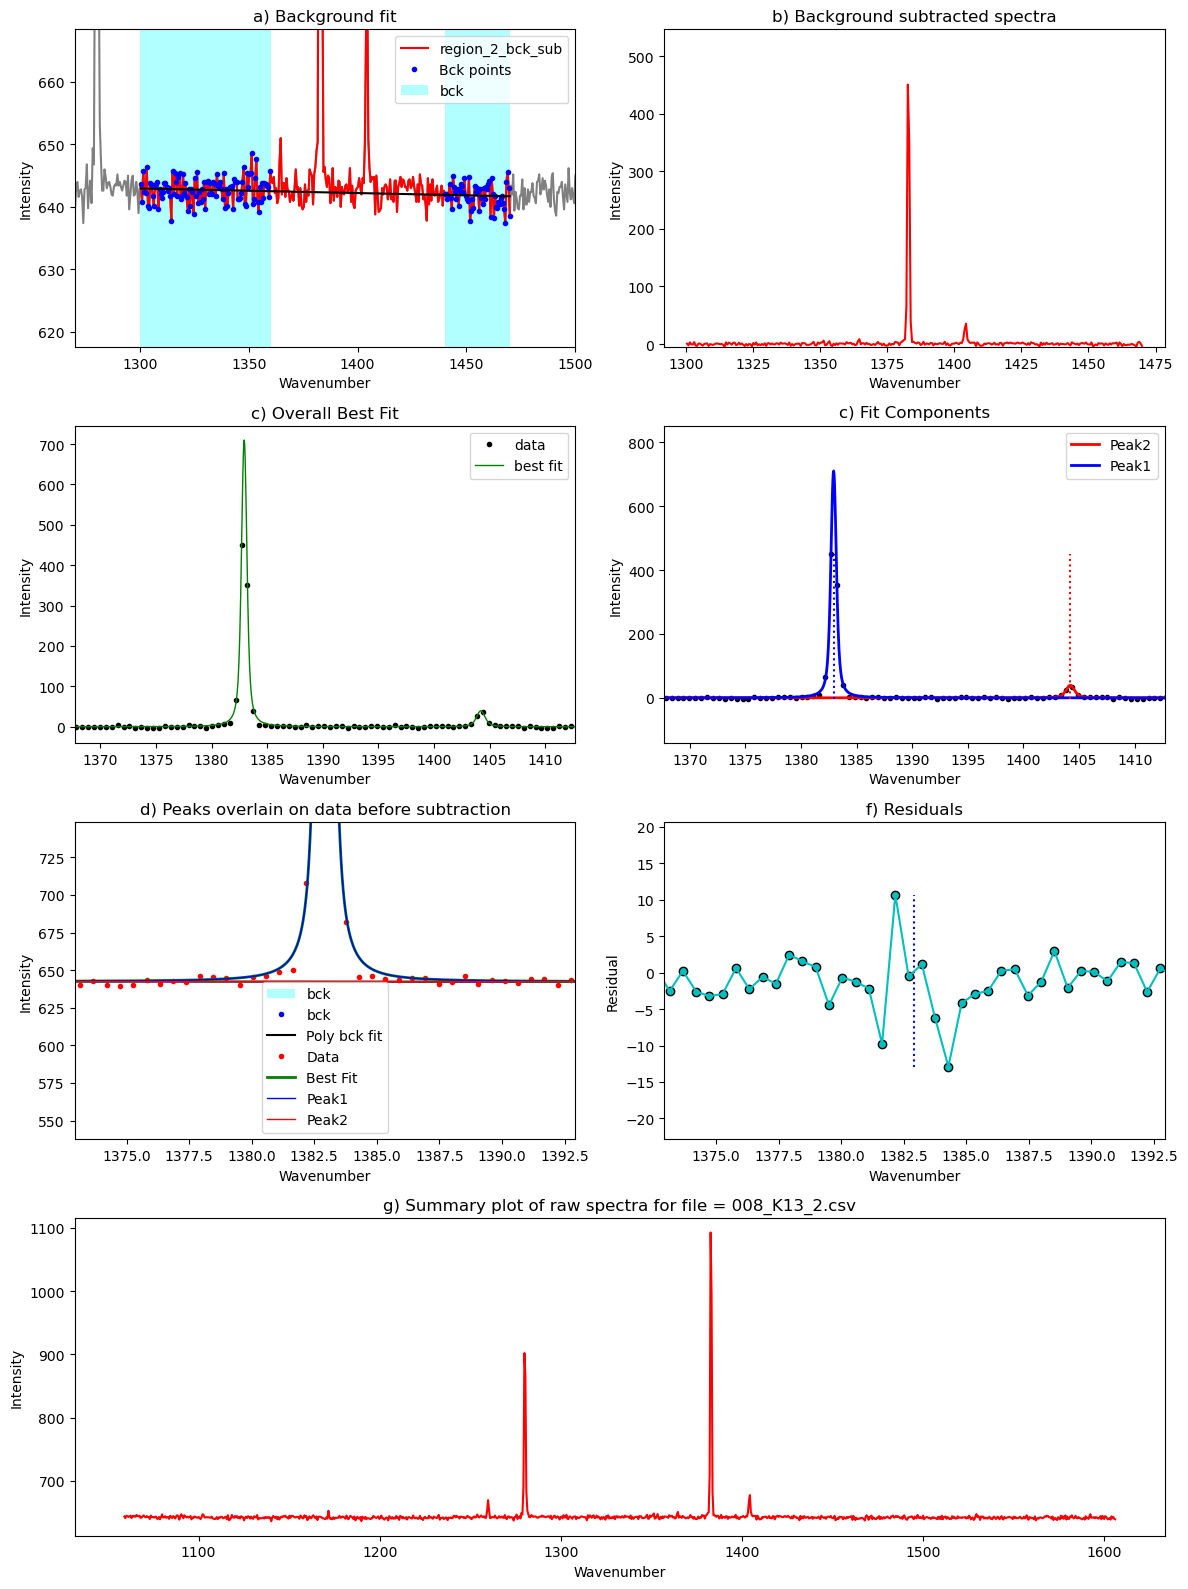

In [16]:
# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad2_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad2_fit

## Combine and save
- Saves to clipboard if to_clipboard=True (e.g. you can paste into a spreadsheet)
- Also saves to 'csv' in a folder in "mypath" if to_csv=True)
- It also makes a new 

In [17]:
out=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, to_clipboard=True, to_csv=True, path=mypath,
Diad2_fit=Diad2_fit, Carb_fit=Carb_fit)
out

,filename,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,HB2_Cent,HB2_Area,C13_Cent,C13_Area
0,008_K13_2.csv,102.810819,1280.117202,354.027089,1.397676,1382.928021,555.369636,1.710057,1259.827333,32.018928,1404.203157,48.592651,NaN,0


In [18]:
out

,filename,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,HB2_Cent,HB2_Area,C13_Cent,C13_Area
0,008_K13_2.csv,102.810819,1280.117202,354.027089,1.397676,1382.928021,555.369636,1.710057,1259.827333,32.018928,1404.203157,48.592651,NaN,0


## You can also try looping if all your spectra are pretty similar

working on 002_K9_1.csv
1382.7101195840469
<Parameter 'sigma', value=0.2332236874188598 +/- 0.00178, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_3412\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on 004_K9_2.csv
1382.7246623434032
<Parameter 'sigma', value=0.23133658414987068 +/- 0.00169, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_3412\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on 006_K13_1.csv
1382.9193194367963
<Parameter 'sigma', value=0.155154476168337 +/- 0.00617, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_3412\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on 007_k9.csv
1381.8958231571883
<Parameter 'sigma', value=0.21820618596922747 +/- 0.00347, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_3412\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on 008_K13_2.csv
1382.9279739321796
<Parameter 'sigma', value=0.16341239834033727 +/- 0.00611, bounds=[0:inf]>
made df
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'HB2_Cent', 'HB2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_3412\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


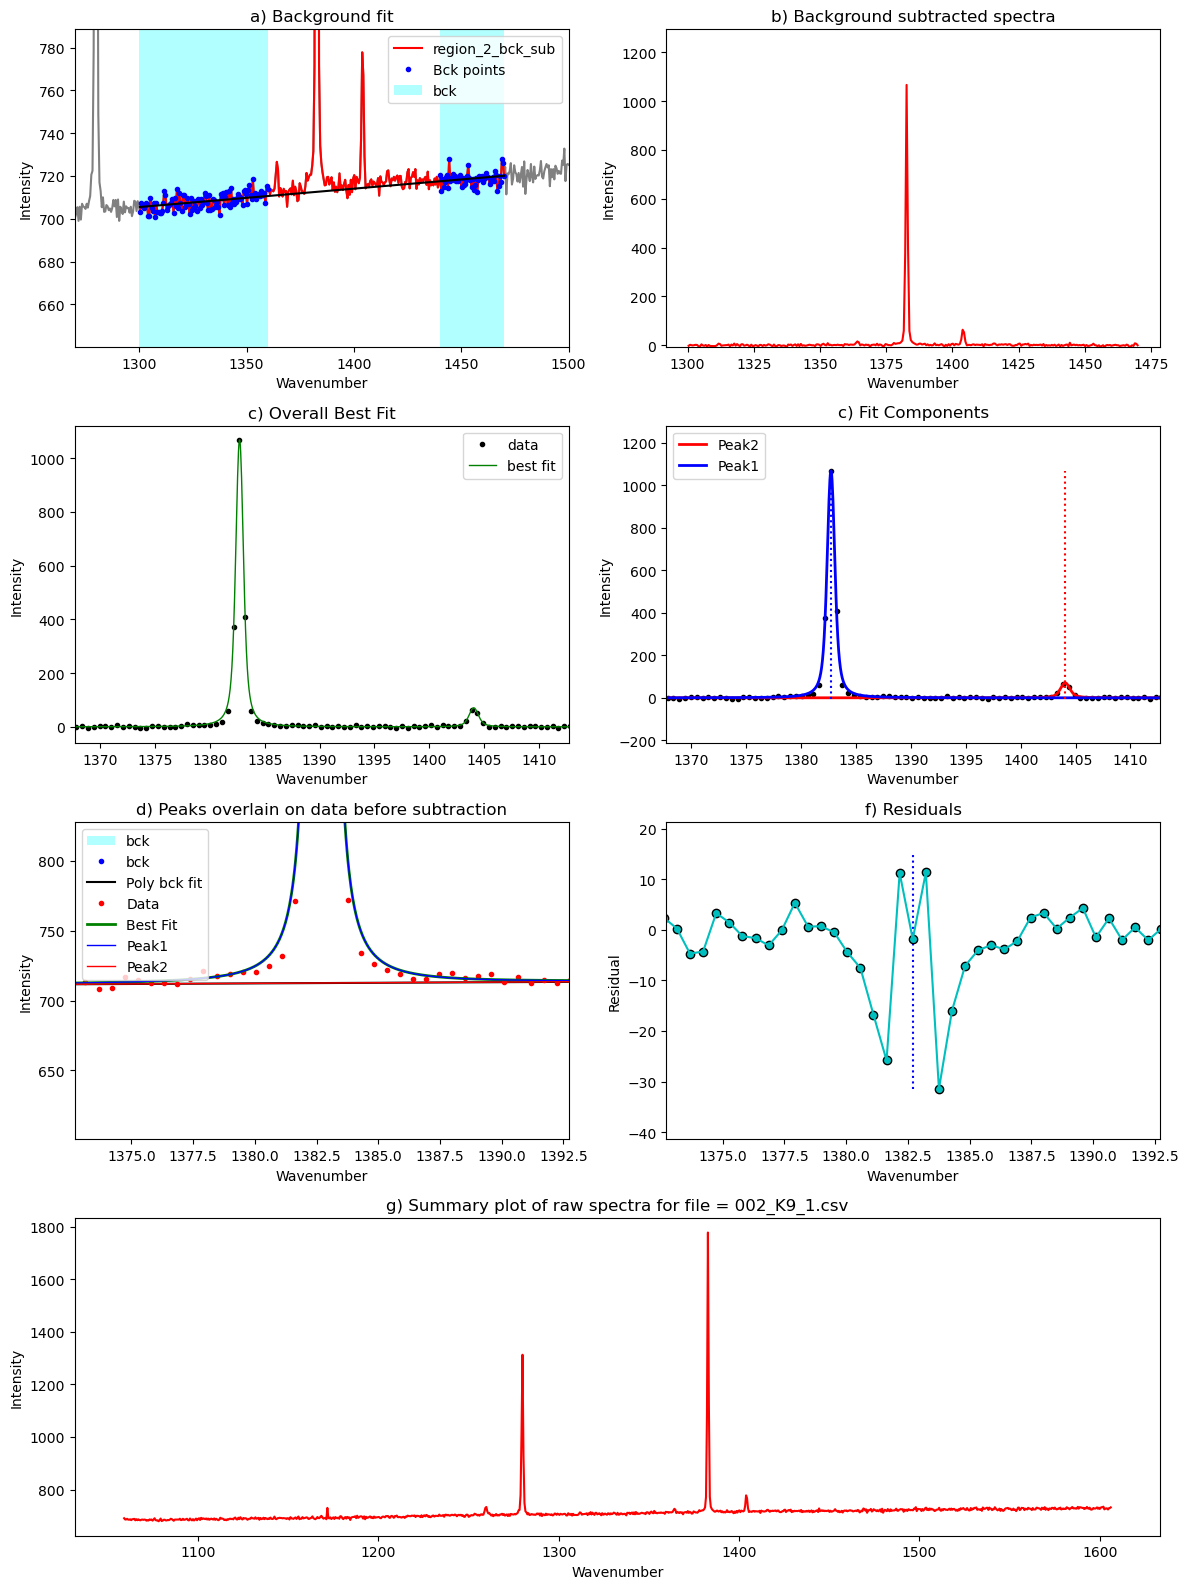

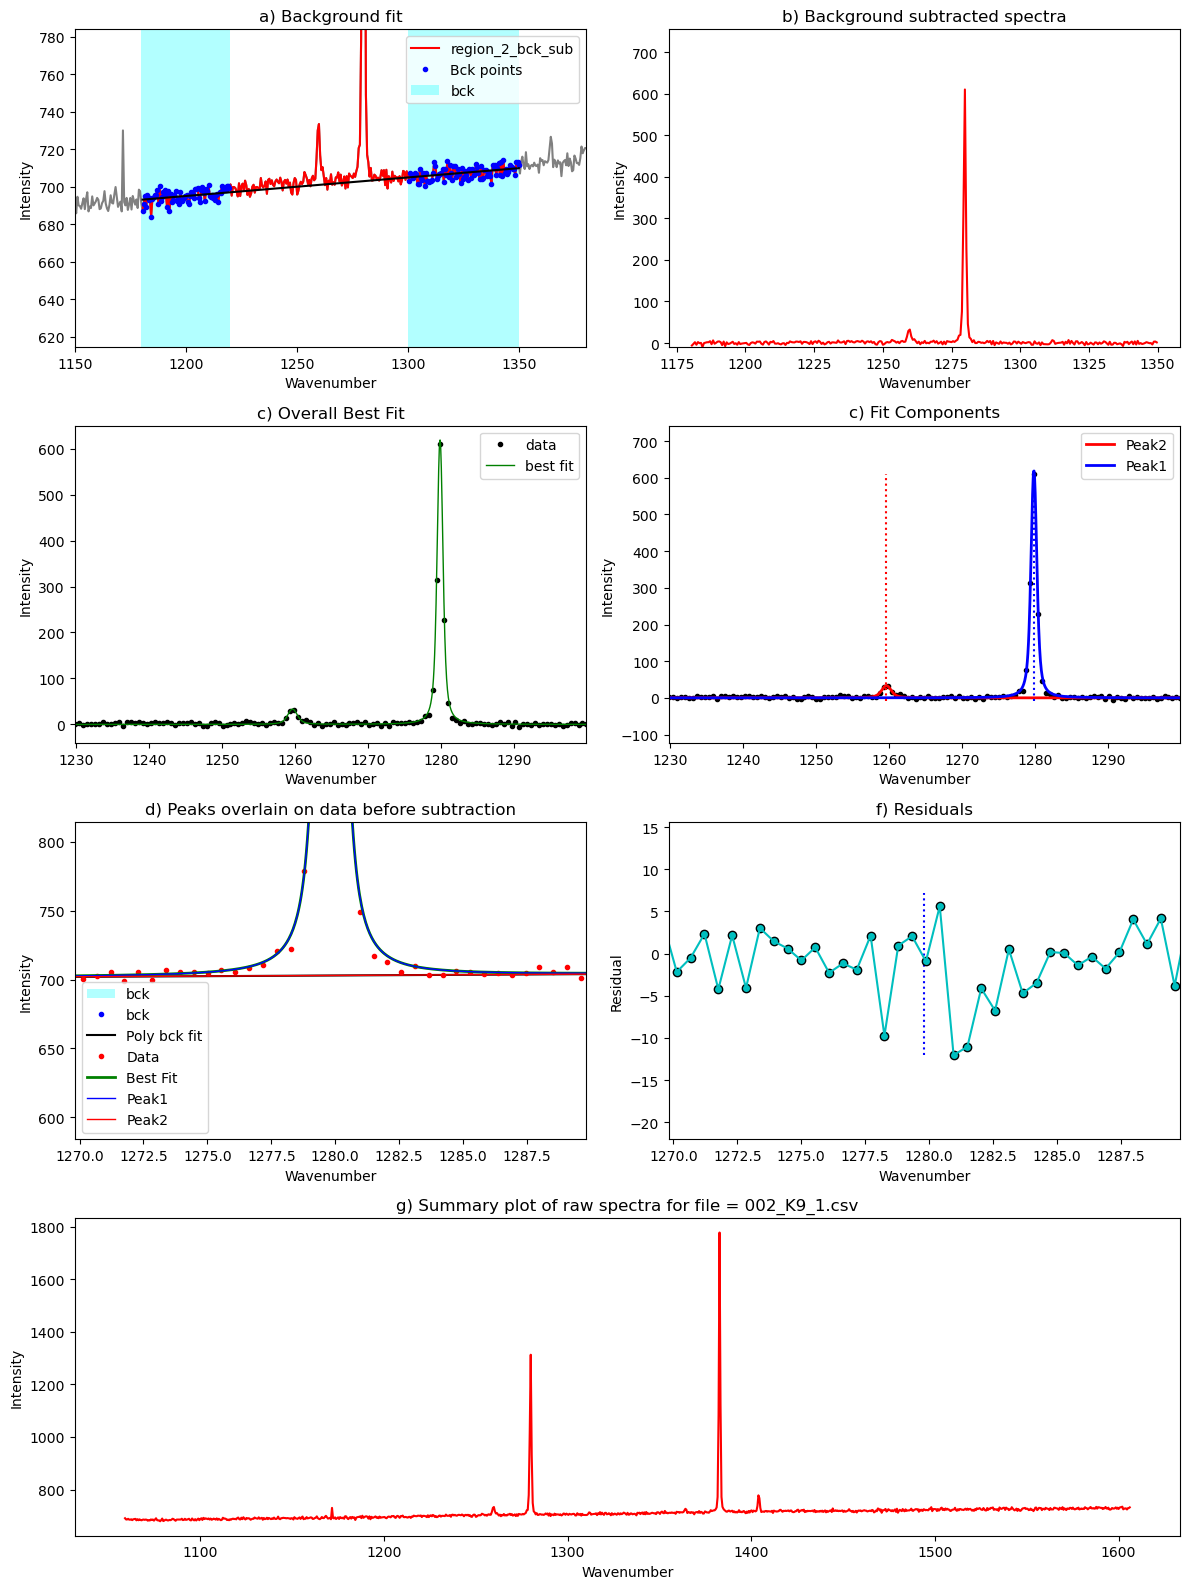

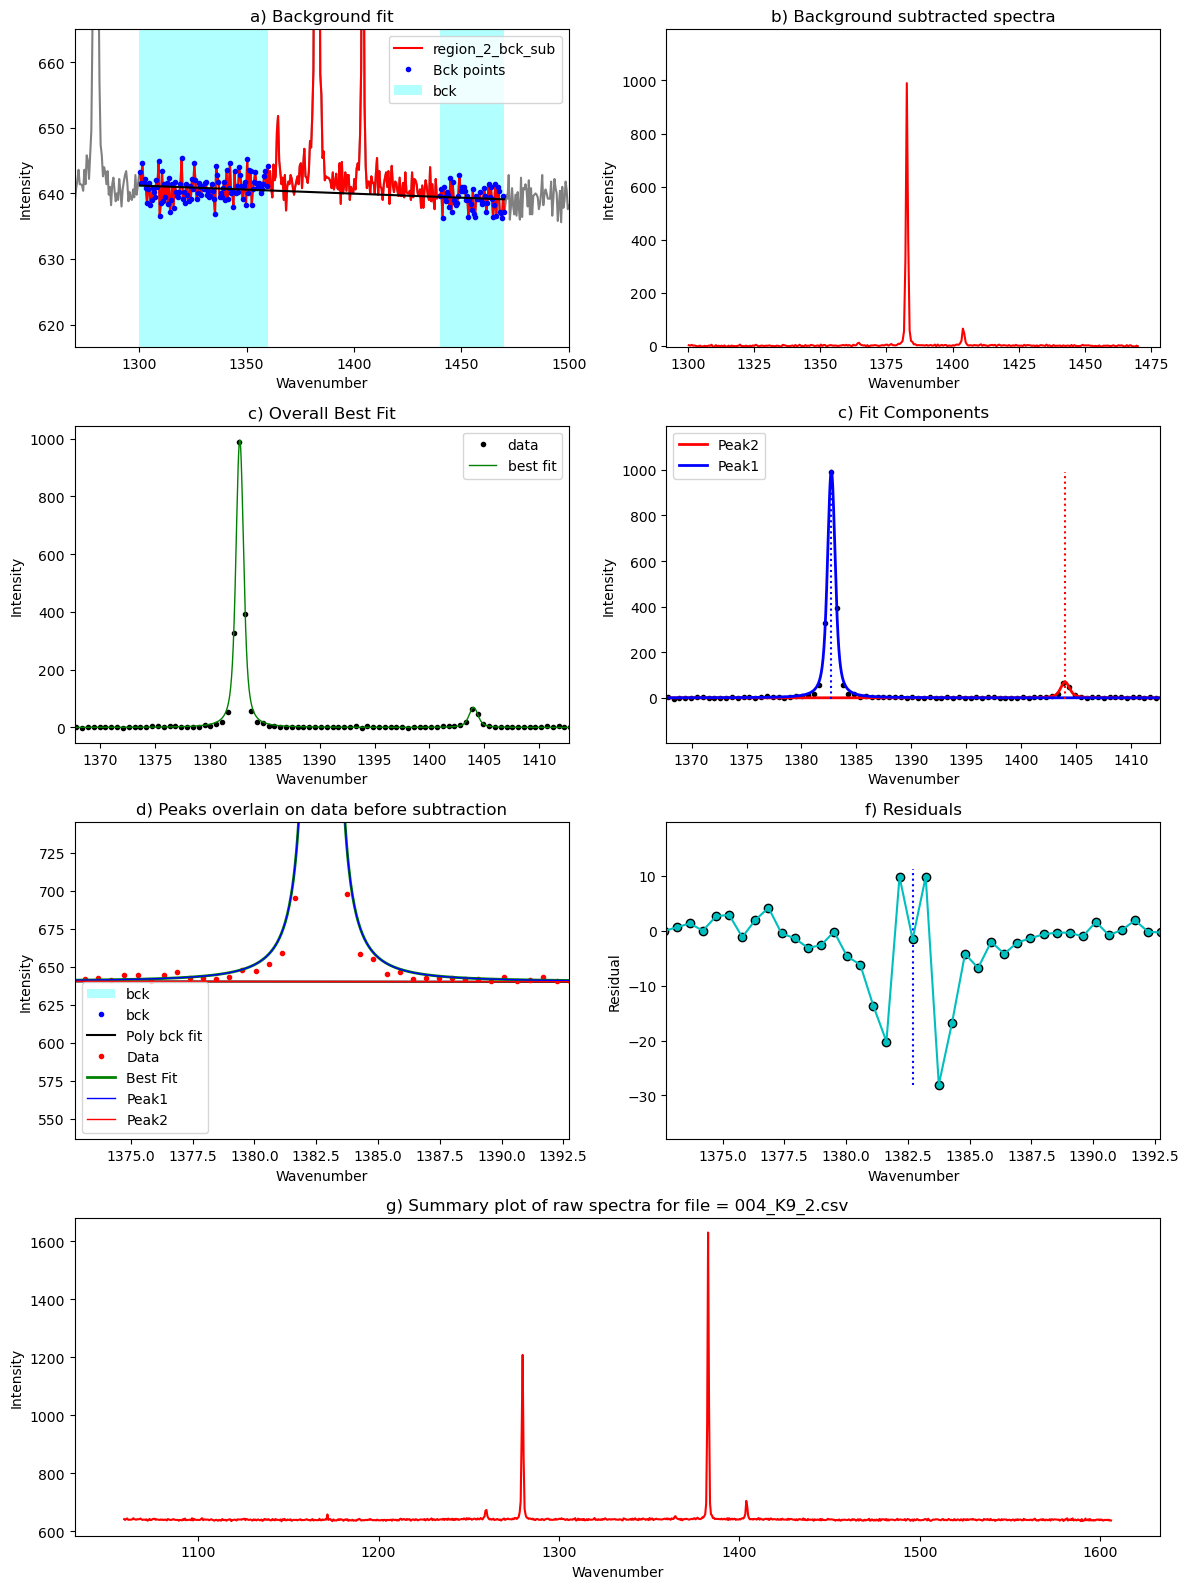

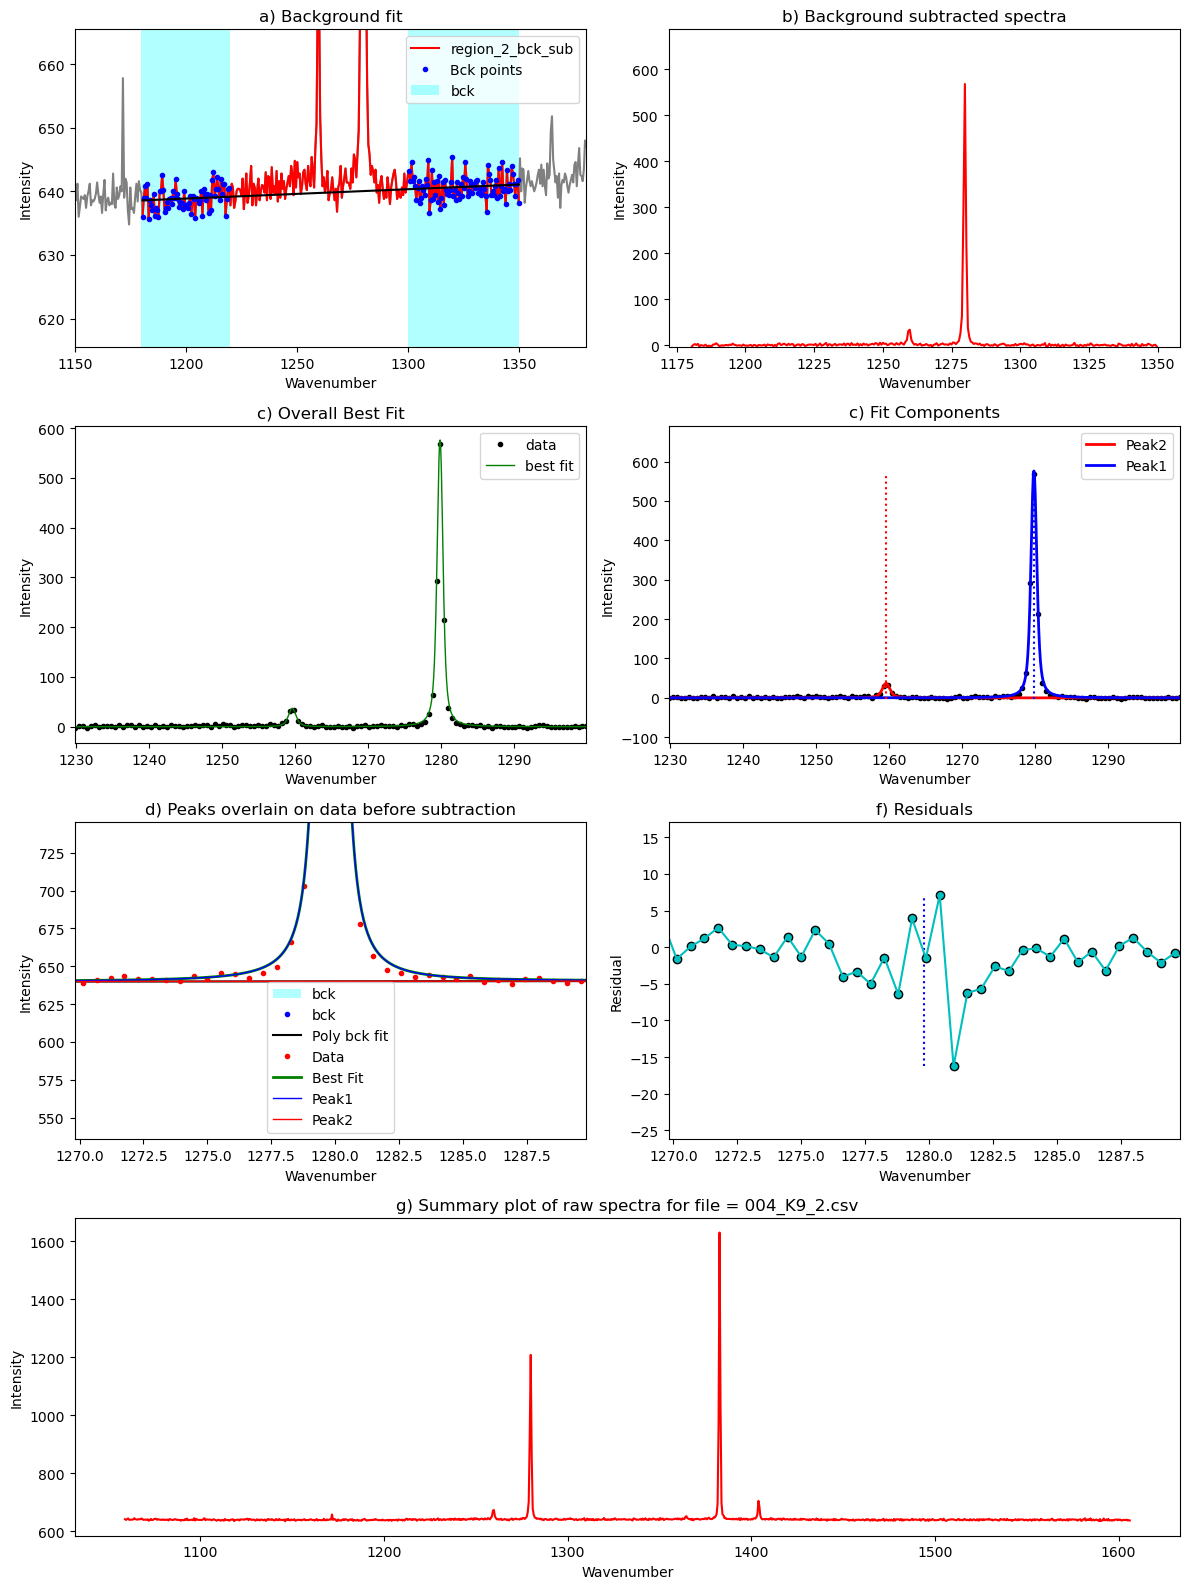

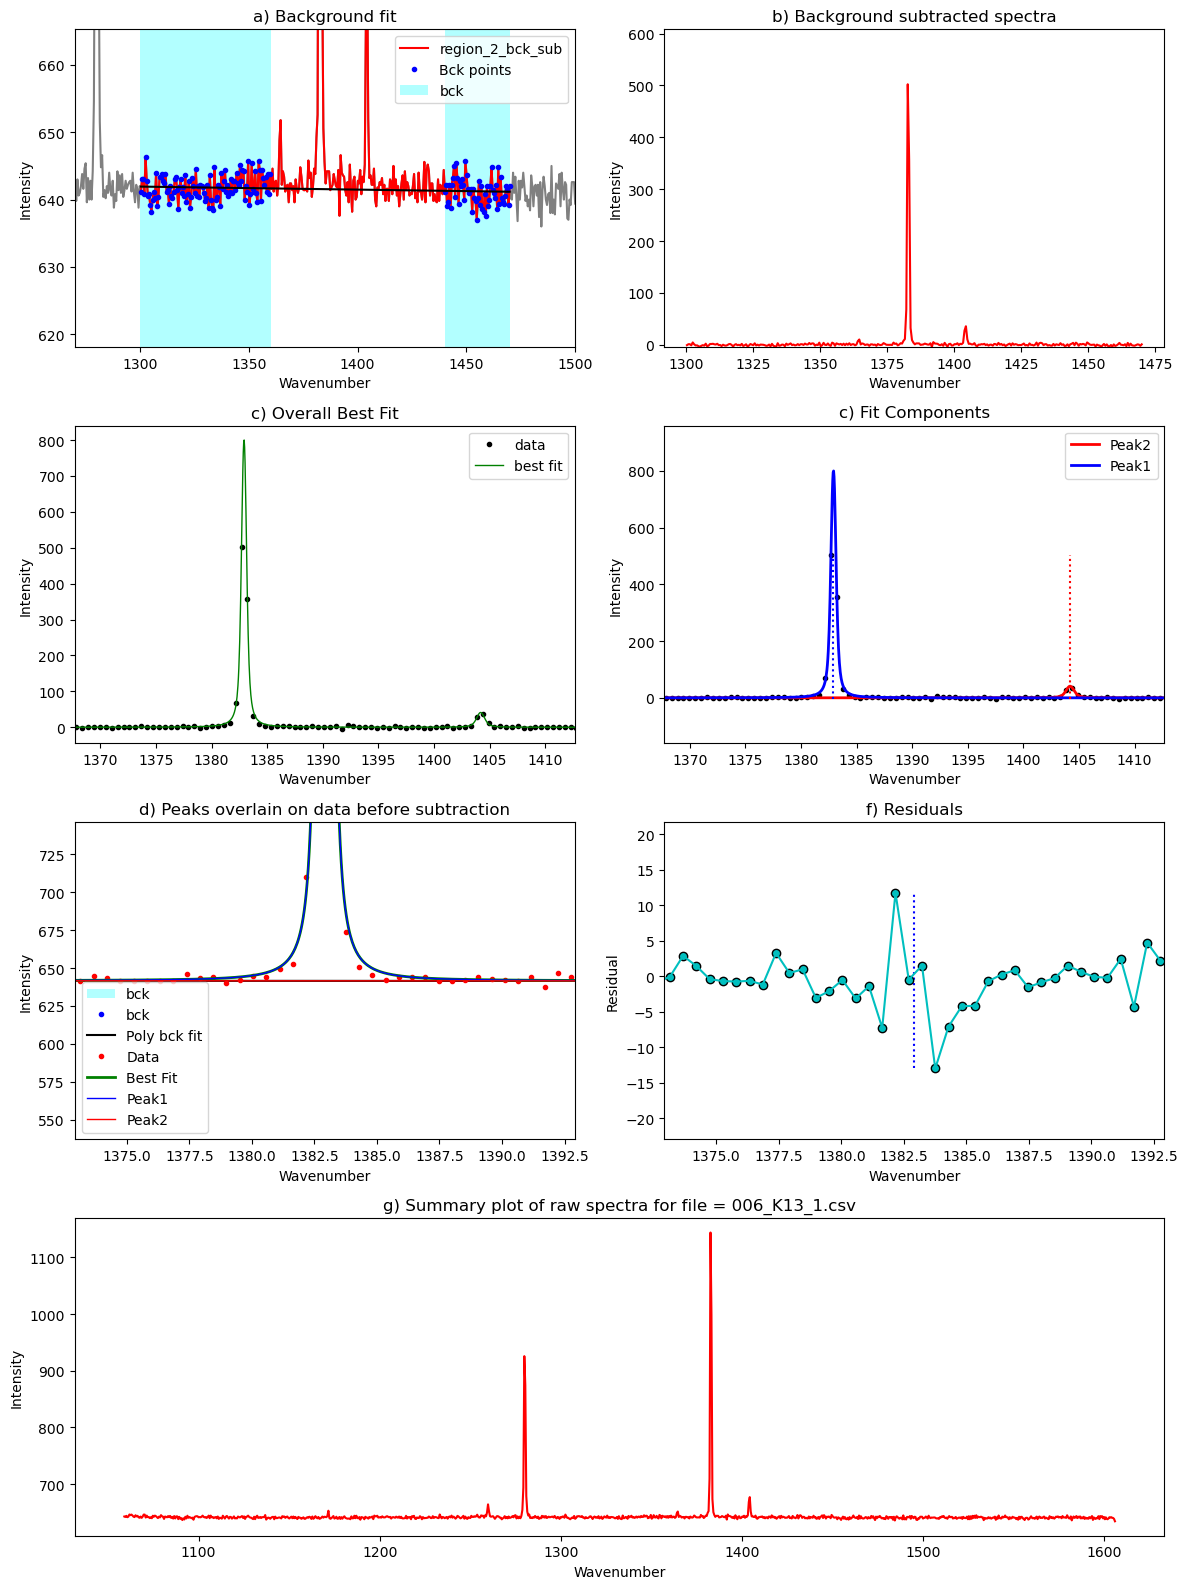

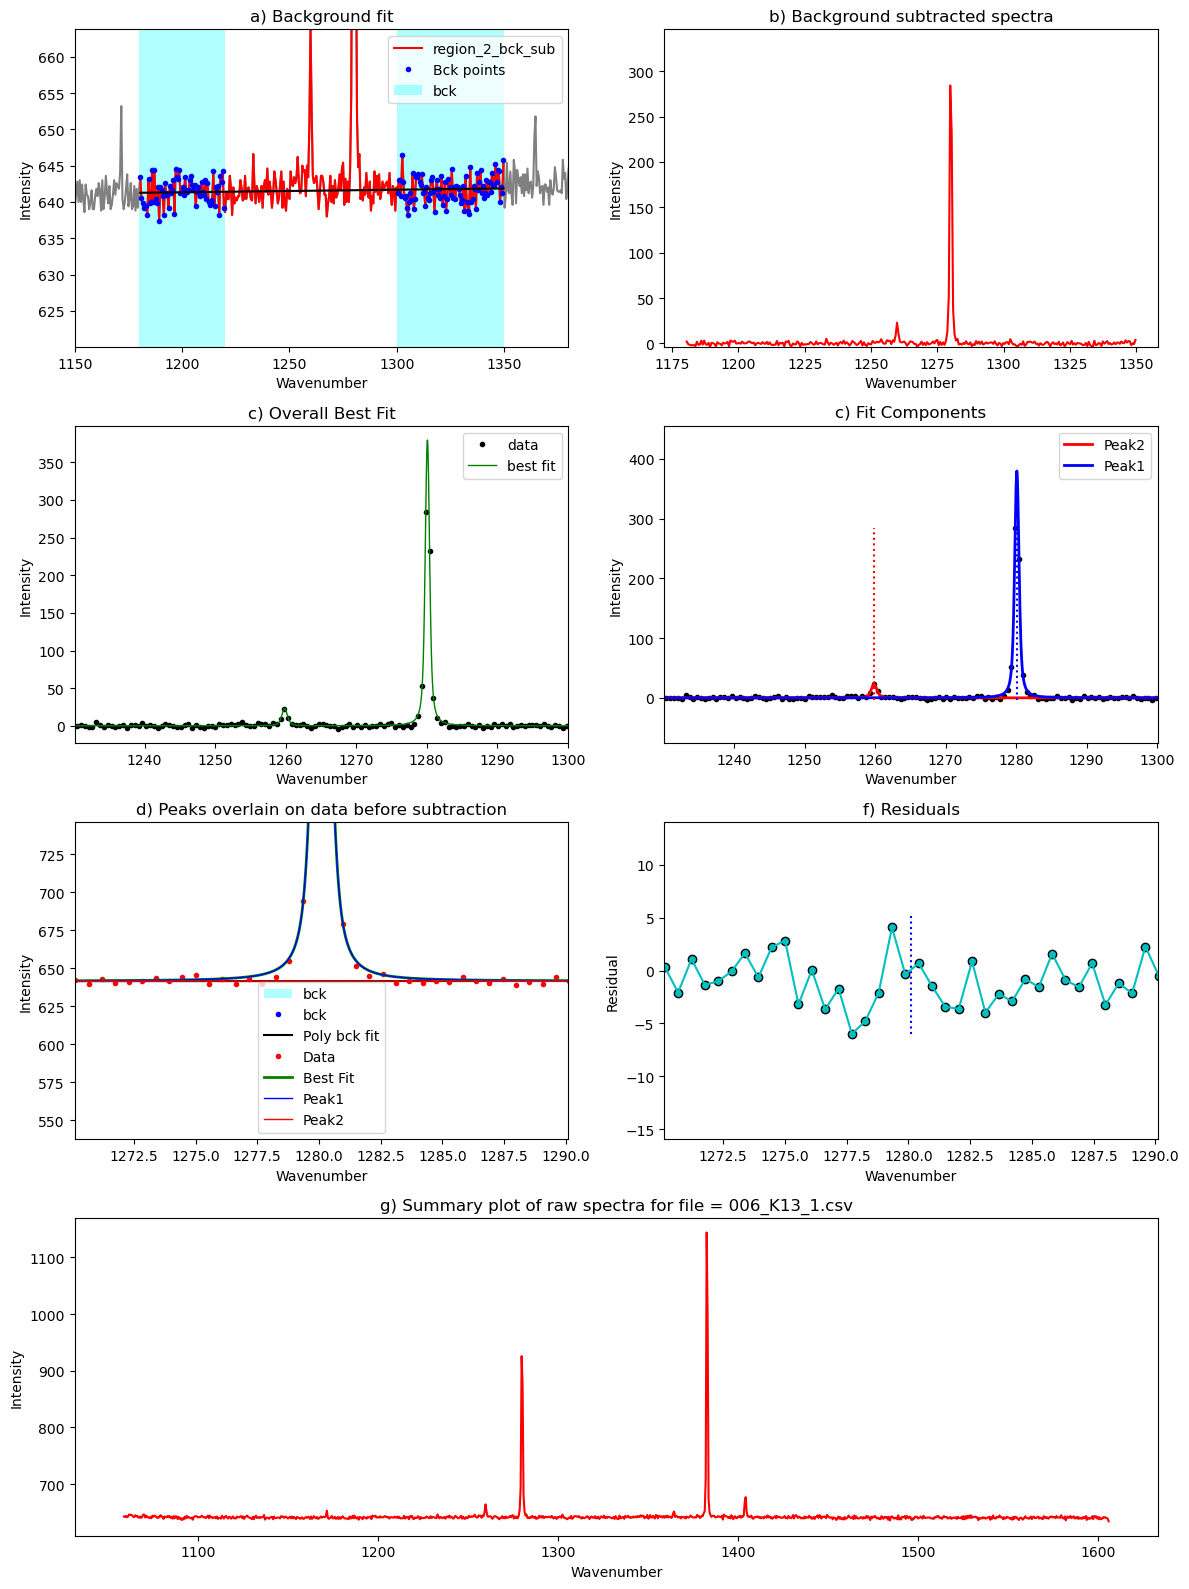

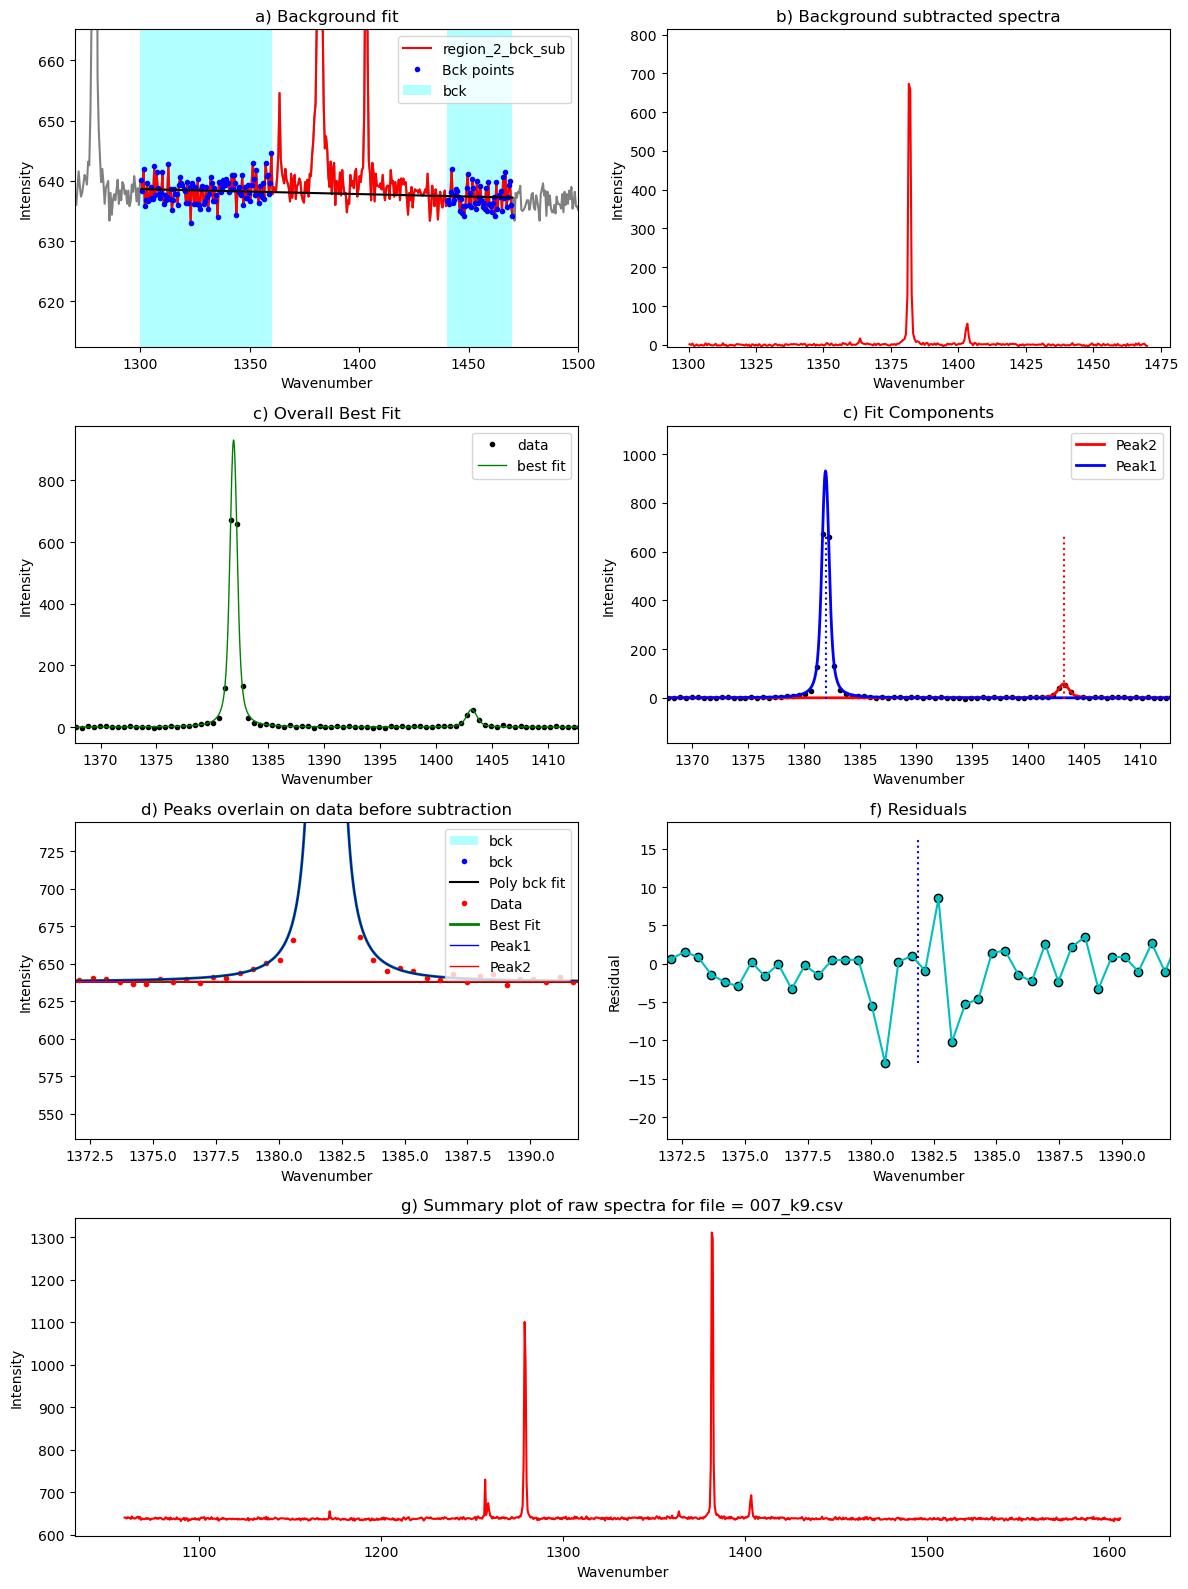

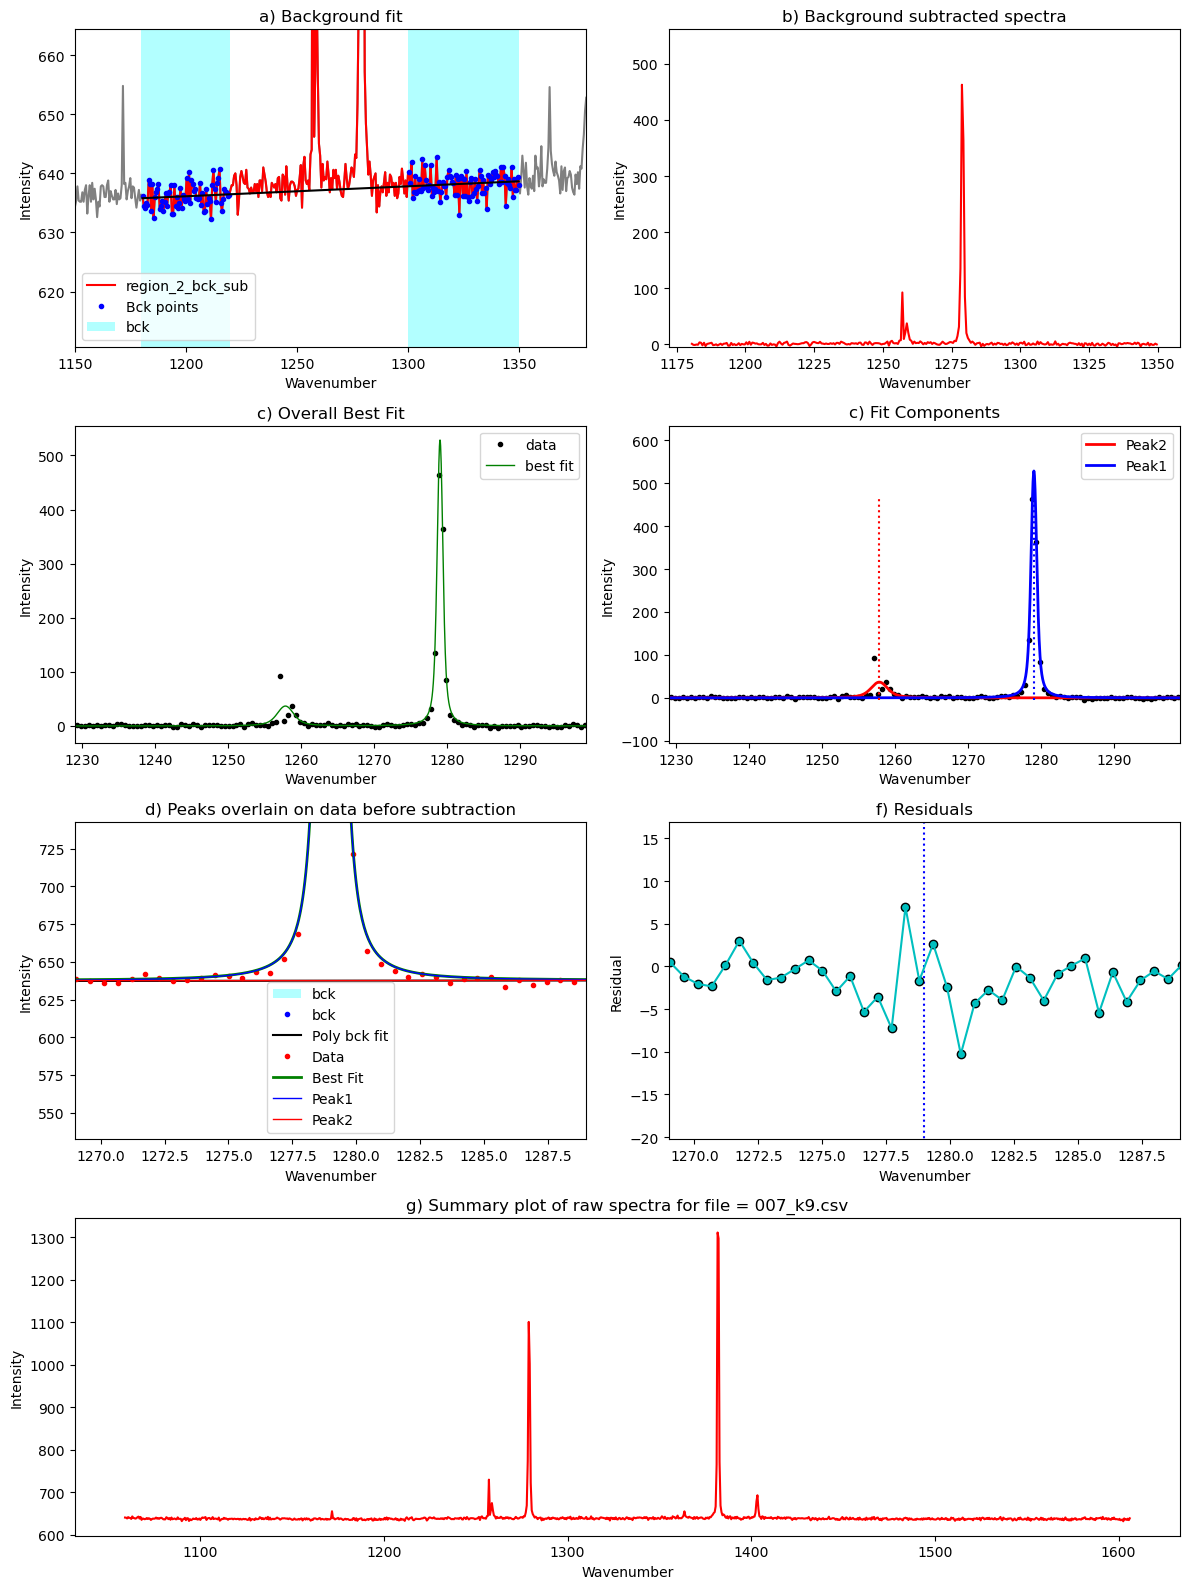

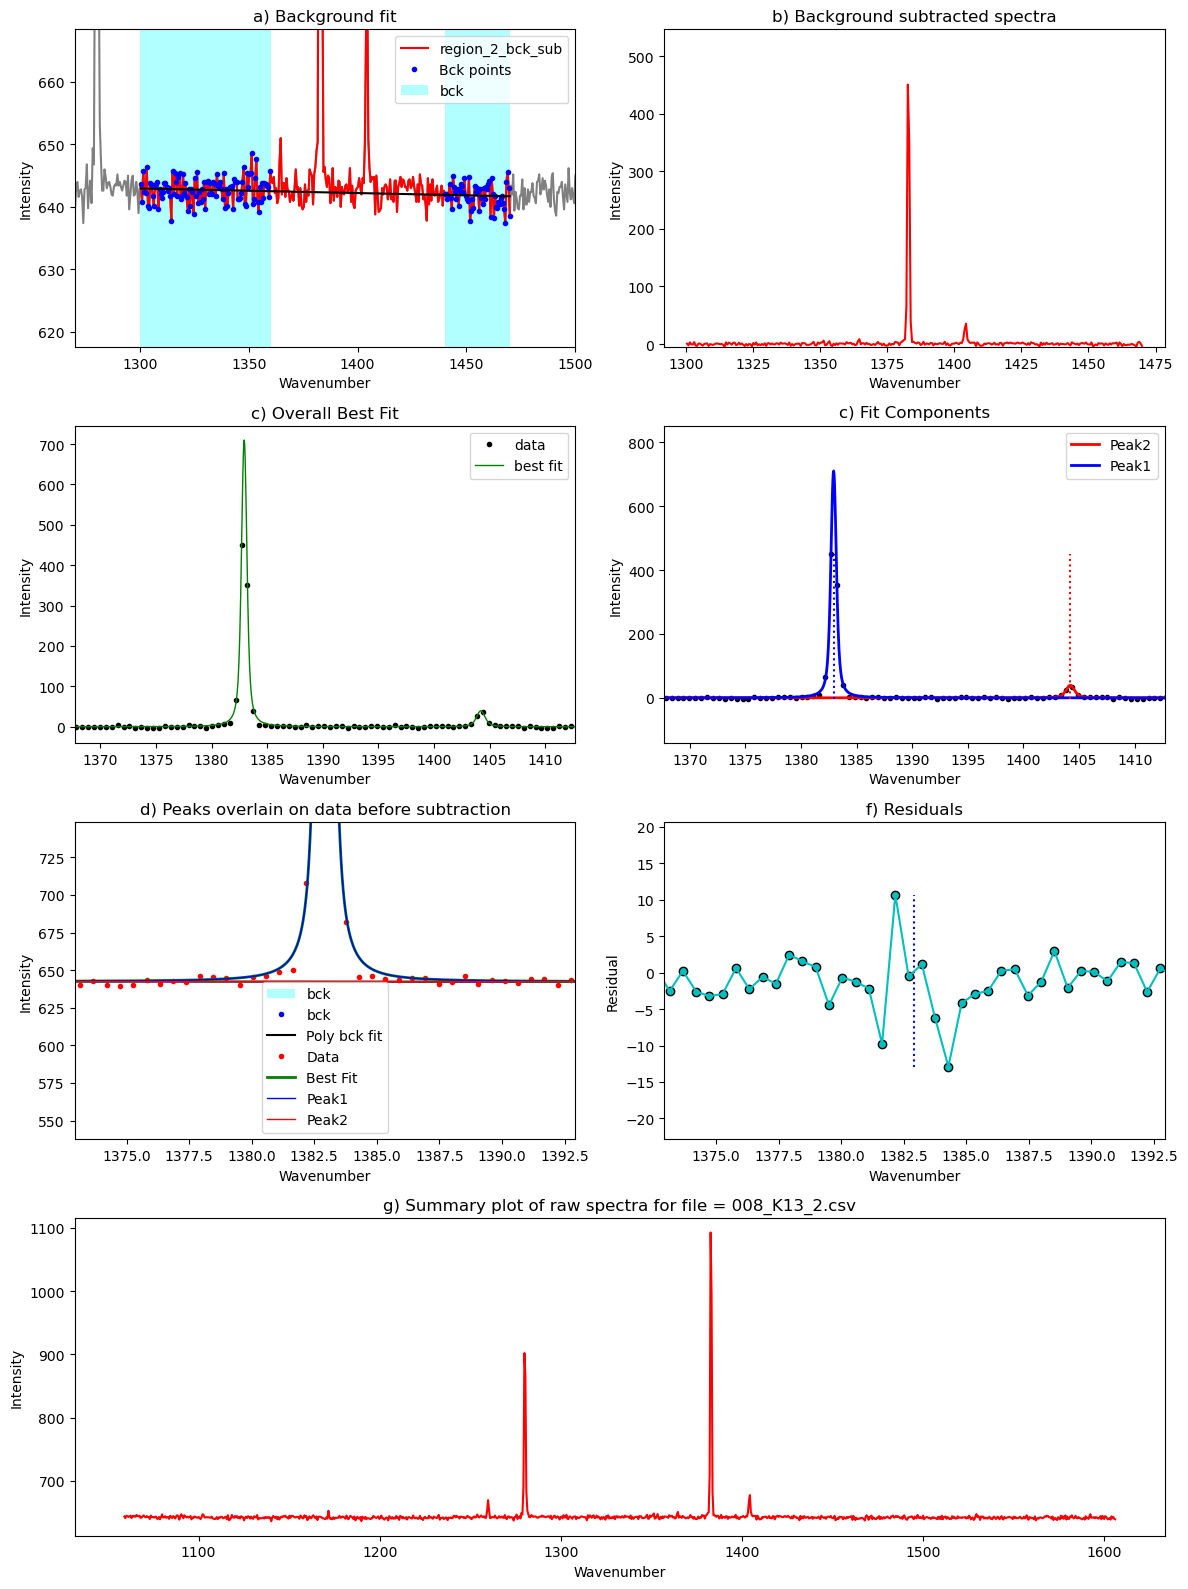

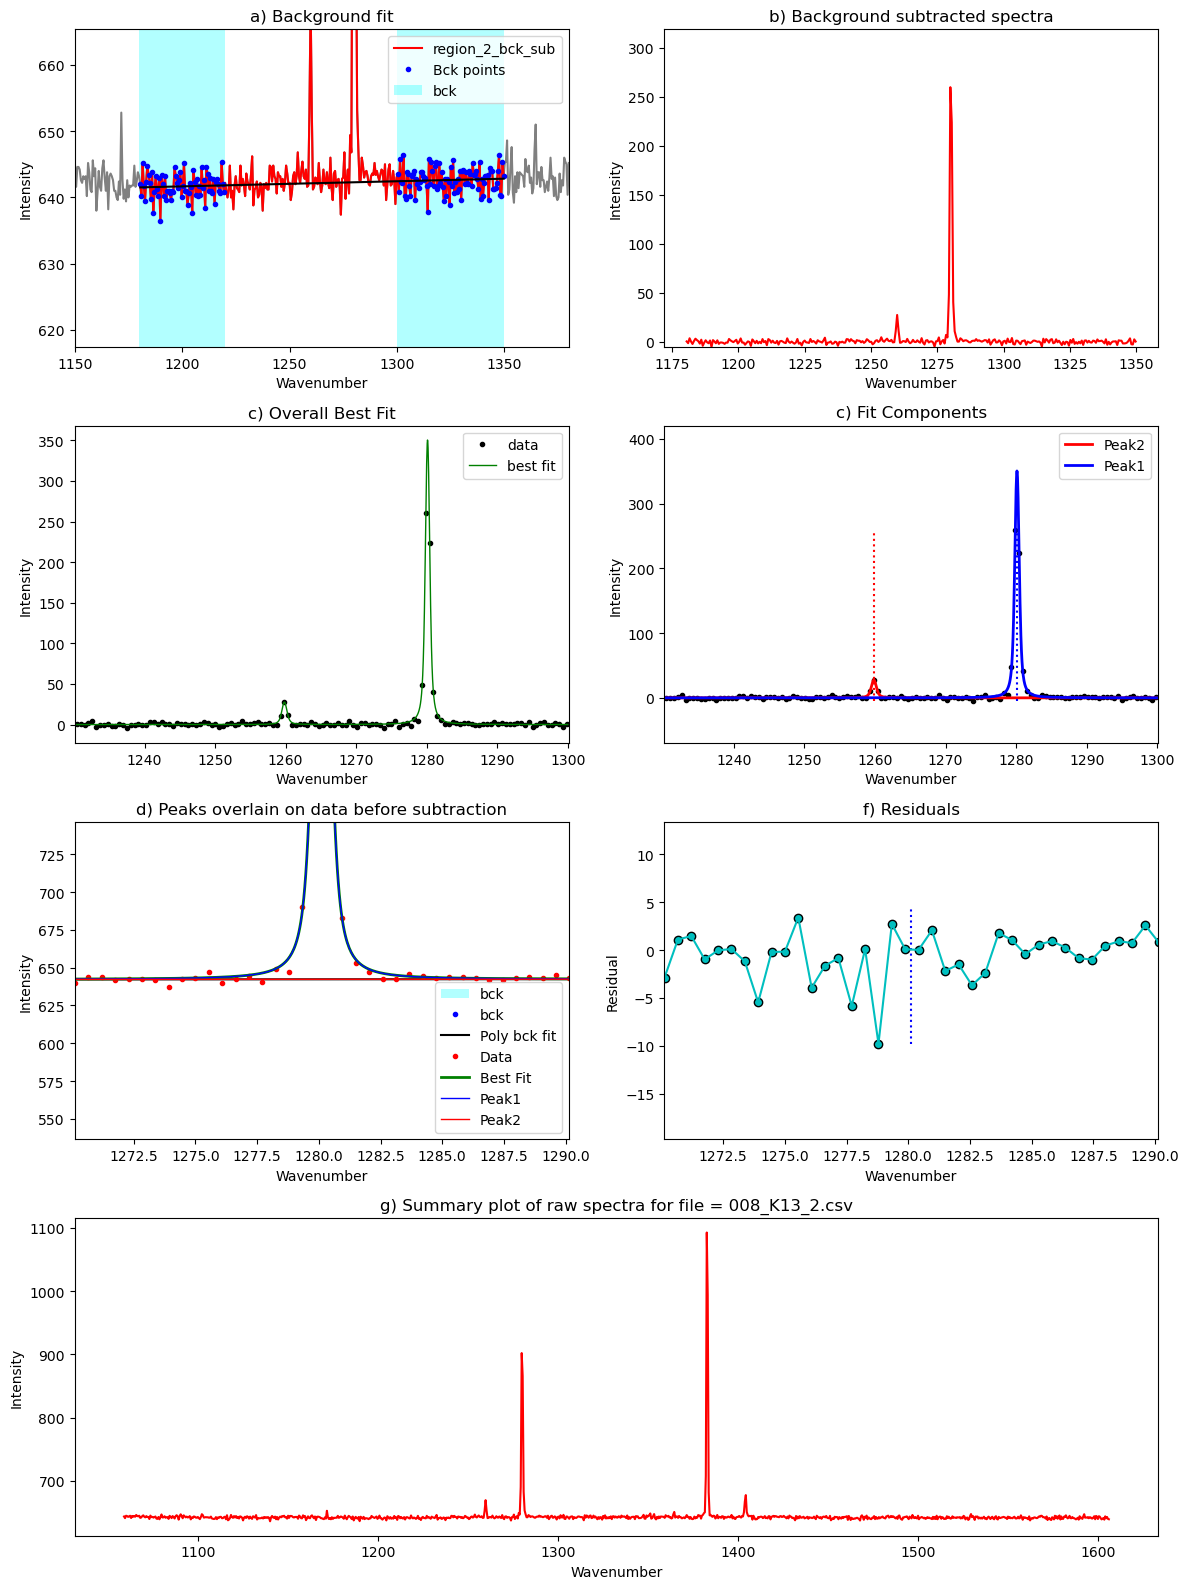

In [21]:
plot_figure=True # Means doesnt make figures, lot faster. 
save_excel=True # Saves to excel
save_clipboard=True # Copies to clipboard

df = pd.DataFrame([])
for i in range(0, len(Diad_files)):
    
    filename=Diad_files[i]
    Ne=pf.get_data(path=mypath, filename=filename, filetype=filetype)
    print('working on ' + str(Diad_files[i]))


    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,
    path=mypath, filename=filename, filetype=filetype)
    
    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
    
    data=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, path=mypath,
Diad2_fit=Diad2_fit)
 

    df = df.append(data)
df2=df.reset_index(drop=True)

In [22]:
df2

,filename,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,HB2_Cent,HB2_Area,C13_Cent,C13_Area
0,002_K9_1.csv,102.897090,1279.813031,791.123454,2.613522,1382.710121,1194.351450,3.257342,1259.620176,70.496548,1404.047658,97.695108,NaN,0
1,004_K9_2.csv,102.910176,1279.814491,735.614855,1.852133,1382.724667,1103.060619,2.301887,1259.577689,61.185501,1404.017108,91.360820,NaN,0
2,006_K13_1.csv,102.811437,1280.107942,376.001672,1.462710,1382.919379,595.017973,1.649136,1259.857433,29.222969,1404.200951,48.483059,NaN,0
3,007_k9.csv,102.905360,1278.990464,670.532845,2.658687,1381.895824,972.534232,1.854759,1257.823244,134.210641,1403.184345,85.963083,NaN,0
4,008_K13_2.csv,102.810819,1280.117202,354.027089,1.397676,1382.928021,555.369636,1.710057,1259.827333,32.018928,1404.203157,48.592651,NaN,0


## Extracting metadata for these diads

In [23]:
meta_path=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Weak_Diad_BenBlack\metadata'
# Find files


# Put the common string you can in all your Ne lines here
ID_str='_'
file_ext_meta='txt' # Will only take files of this type 
exclude_str='Ne' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files_meta=pf.get_Ne_files(path=meta_path, file_ext=file_ext_meta, ID_str=ID_str, 
                         exclude_str=exclude_str, sort=True)

Ne_files_meta


['002_K9_1--Information.txt',
 '004_K9_2--Information.txt',
 '006_K13_1--Information.txt',
 '008_K13_2--Information.txt']

In [24]:
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False)

working on file002_K9_1--Information.txt
working on file004_K9_2--Information.txt
working on file006_K13_1--Information.txt
working on file008_K13_2--Information.txt
Done


In [25]:
meta

,filename,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,index
0,002_K9_1--Information.txt,"September 27, 2022\n",NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:06:14 PM\n,47174.0,0
1,004_K9_2--Information.txt,"September 27, 2022\n",NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:14:54 PM\n,47694.0,1
2,006_K13_1--Information.txt,"September 27, 2022\n",NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:27:11 PM\n,48431.0,2
3,008_K13_2--Information.txt,"September 27, 2022\n",NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:35:25 PM\n,48925.0,3


## Stitching metadata and data together

In [26]:
meta['filename'][0]

'002_K9_1--Information.txt'

In [27]:
df2['filename'][0]

'002_K9_1.csv'

In [28]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=True, str_prefix='_',
    suffix=True, str_suffix='--',
   file_type='.txt')

file_m

array(['K9_1', 'K9_2', 'K13_1', 'K13_2'], dtype=object)

In [29]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=True, str_prefix='_',
   file_type='.csv')
file_s

array(['K9_1', 'K9_2', 'K13_1', 'k9', 'K13_2'], dtype=object)

In [30]:
# Combining them together
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now load in the model for doing the Ne fitting

In [31]:
from pickle import load
import pickle

pickle_path='G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Weak_Diad_BenBlack'
file_pkl=pickle_path + '/' + 'Ne_Line_Regression_ExampleBlack.pck'
with open(file_pkl, 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

In [32]:
df_combo['Ne_Correction']=my_loaded_model(df_combo['sec since midnight'])
df_combo['Corrected_Splitting']=df_combo['Ne_Correction']*df_combo['Splitting']

In [33]:
df_combo

,filename_x,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,...,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,index,Ne_Correction,Corrected_Splitting
0,002_K9_1.csv,102.897090,1279.813031,791.123454,2.613522,1382.710121,1194.351450,3.257342,1259.620176,70.496548,...,NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:06:14 PM\n,47174.0,0,1.000434,102.941727
1,004_K9_2.csv,102.910176,1279.814491,735.614855,1.852133,1382.724667,1103.060619,2.301887,1259.577689,61.185501,...,NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:14:54 PM\n,47694.0,1,1.000438,102.955278
2,006_K13_1.csv,102.811437,1280.107942,376.001672,1.462710,1382.919379,595.017973,1.649136,1259.857433,29.222969,...,NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:27:11 PM\n,48431.0,2,1.000445,102.857146
3,008_K13_2.csv,102.810819,1280.117202,354.027089,1.397676,1382.928021,555.369636,1.710057,1259.827333,32.018928,...,NaN,30.0,5.0,50.0,"['0h', '2m', '32s']",1:35:25 PM\n,48925.0,3,1.000449,102.856964
